## 1.Environment Setup

In [1]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán giữa các lần chạy
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"Seed: {SEED}")

Seed: 42


## 2.Data Processing

In [2]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)

    return X, y

### 2.1 Original Dataset

In [3]:
X_train, y_train = read_csv('splits/raw_train.csv')
X_val, y_val = read_csv('splits/raw_val.csv')
X_test, y_test = read_csv('splits/raw_test.csv')

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0,1
1,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0,0
3,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0,0
4,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0,0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0,1
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0,0
3,0.941197,0.229802,0.040979,0.973394,-0.891627,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.495681,0.229802,-0.300333,0.487519,-0.445445,1.0,1.000000,0.0,0.0,0.0,0.5,0.0,1.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.384303,-0.168240,-0.641646,-0.837597,1.071575,1.0,1.000000,0.0,1.0,1.0,0.5,1.0,1.0,1
1,-2.288787,-0.736870,-1.286348,1.061736,-0.891627,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.829818,-0.054513,-0.357219,-0.175039,0.714629,1.0,0.666667,0.0,0.0,0.0,0.5,1.0,1.0,0
3,-0.395349,-0.054513,0.116827,-0.042528,-0.445445,0.0,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0
4,-1.397757,-0.623144,-0.186562,1.945146,-0.177735,1.0,0.666667,1.0,0.0,0.0,1.0,0.0,1.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)


### 2.2 FE Dataset

In [4]:
X_fe_train, y_fe_train = read_csv('splits/fe_train.csv')
X_fe_val, y_fe_val = read_csv('splits/fe_val.csv')
X_fe_test, y_fe_test = read_csv('splits/fe_test.csv')

,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
3,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
4,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 14)
Shape X:  (242, 13)
Shape y:  (242,)


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,1.0,0.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.262410,1.0,0.089984,0.628019,0.0,0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.250048,0.0,1.368307,1.0,-1.809349,-1.592443,1.0,1
2,0.0,1.0,0.0,1.0,0.0,1.0,0.536156,1.0,-0.338257,0.0,0.664201,0.235034,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.040979,0.0,0.973394,-0.161823,0.0,0
4,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,-0.300333,1.0,0.487519,-0.163464,1.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 14)
Shape X:  (30, 13)
Shape y:  (30,)


,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
0,0.0,1.0,1.0,0.0,1.0,0.0,1.071575,0.0,-0.641646,1.0,-0.837597,-0.736915,1.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,-1.286348,0.0,1.061736,2.749978,1.0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.714629,0.0,-0.357219,1.0,-0.175039,-0.619566,1.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,-0.445445,1.0,0.116827,0.0,-0.042528,0.071622,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,-0.177735,0.0,-0.186562,0.0,1.945146,2.141882,1.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 14)
Shape X:  (31, 13)
Shape y:  (31,)


### 2.3 Original + DT Dataset

In [5]:
# Original + DT Dataset
X_dt_train, y_dt_train = read_csv('splits/dt_train.csv')
X_dt_val, y_dt_val = read_csv('splits/dt_val.csv')
X_dt_test, y_dt_test = read_csv('splits/dt_test.csv')

,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0,1
1,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0,0
2,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0,0
3,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0,0
4,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,0.0,1.000000,0.0,-0.713154,-0.262410,-1.063621,0.089984,0.0,0.5,1.0,0
1,0.0,1.000000,1.0,1.250048,1.368307,1.720848,-1.809349,1.0,0.5,0.0,1
2,1.0,0.666667,0.0,0.536156,-0.338257,-0.061212,0.664201,1.0,0.0,0.0,0
3,0.0,0.666667,0.0,-0.891627,0.040979,0.941197,0.973394,0.0,0.0,0.0,0
4,1.0,1.000000,0.0,-0.445445,-0.300333,0.495681,0.487519,1.0,0.5,0.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang,target
0,1.0,1.000000,1.0,1.071575,-0.641646,0.384303,-0.837597,1.0,0.5,1.0,1
1,0.0,0.000000,0.0,-0.891627,-1.286348,-2.288787,1.061736,1.0,0.0,0.0,0
2,1.0,0.666667,1.0,0.714629,-0.357219,0.829818,-0.175039,1.0,0.5,0.0,0
3,0.0,0.666667,0.0,-0.445445,0.116827,-0.395349,-0.042528,0.0,0.0,0.0,0
4,1.0,0.666667,0.0,-0.177735,-0.186562,-1.397757,1.945146,1.0,1.0,0.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)


### 2.4 FE + DT Dataset

In [6]:
# FE + DT Dataset
X_fe_dt_train, y_fe_dt_train = read_csv('splits/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('splits/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('splits/fe_dt_test.csv')
print("Finish!")

,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0,1
1,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0,0
2,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0,0
3,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0,0
4,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0,1


target
0    131
1    111
Name: count, dtype: int64

Shape df:  (242, 11)
Shape X:  (242, 10)
Shape y:  (242,)


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,1.0,1.0,1.0,0.524962,0.628019,-0.713154,-0.262410,-1.063621,0.0,0.0,0
1,1.0,1.0,0.0,-0.068646,-1.592443,1.250048,1.368307,1.720848,1.0,0.0,1
2,0.0,0.0,1.0,-0.348393,0.235034,0.536156,-0.338257,-0.061212,1.0,1.0,0
3,1.0,0.0,1.0,-0.621316,-0.161823,-0.891627,0.040979,0.941197,1.0,1.0,0
4,0.0,1.0,1.0,-0.652540,-0.163464,-0.445445,-0.300333,0.495681,1.0,0.0,0


target
0    16
1    14
Name: count, dtype: int64

Shape df:  (30, 11)
Shape X:  (30, 10)
Shape y:  (30,)


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0,target
0,0.0,1.0,0.0,-0.875417,-0.736915,1.071575,-0.641646,0.384303,0.0,0.0,1
1,1.0,0.0,1.0,0.624900,2.749978,-0.891627,-1.286348,-2.288787,1.0,0.0,0
2,0.0,0.0,0.0,-0.873880,-0.619566,0.714629,-0.357219,0.829818,1.0,1.0,0
3,1.0,0.0,1.0,0.317862,0.071622,-0.445445,0.116827,-0.395349,1.0,1.0,0
4,0.0,0.0,1.0,0.957741,2.141882,-0.177735,-0.186562,-1.397757,1.0,1.0,0


target
0    17
1    14
Name: count, dtype: int64

Shape df:  (31, 11)
Shape X:  (31, 10)
Shape y:  (31,)
Finish!


## 3.AdaBoost (AB)

In [7]:
def find_optimal_ada(
    X_train, y_train,
    n_estimators_range=range(50, 501, 50),
    cv_splits=3, learning_rate=0.1,
    base_max_depth=1, algorithm="SAMME"
):
    # Dòng print để kiểm tra, bạn sẽ thấy nó in ra 10 giá trị
    print(f"Đang kiểm tra các giá trị n_estimators: {list(n_estimators_range)}")

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    for n in n_estimators_range:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=base_max_depth, random_state=SEED),
            n_estimators=n, learning_rate=learning_rate,
            algorithm=algorithm, random_state=SEED
        )
        cv_score = cross_val_score(
            ada, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f"n_estimators tối ưu (CV): {best_n}")

    # Vẽ biểu đồ chọn n_estimators theo CV
    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho AdaBoost (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    # Train lại với toàn bộ X_train
    best_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=base_max_depth, random_state=SEED),
        n_estimators=best_n, learning_rate=learning_rate,
        algorithm=algorithm, random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

def evaluate_val_ada(X_train, y_train, X_val, y_val,
                     n_estimators_range=range(50, 501, 50),
                     cv_splits=3, learning_rate=0.1,
                     base_max_depth=1, algorithm="SAMME"):
    print("Tìm n_estimators tối ưu cho AdaBoost...")
    ada_model, best_n, cv_acc = find_optimal_ada(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        learning_rate=learning_rate,
        base_max_depth=base_max_depth,
        algorithm=algorithm
    )

    # Dự đoán & báo cáo trên validation
    val_pred = ada_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"\nĐộ chính xác AdaBoost trên tập validation: {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return ada_model, val_acc, {"n_estimators": best_n}

def evaluate_test_ada(ada_model, X_test, y_test):
    test_pred = ada_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\nĐộ chính xác AdaBoost trên tập test: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, test_pred))
    return test_acc

### 3.1 AB on Original Dataset

Tìm n_estimators tối ưu cho AdaBoost...
Đang kiểm tra các giá trị n_estimators: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]


n_estimators tối ưu (CV): 50


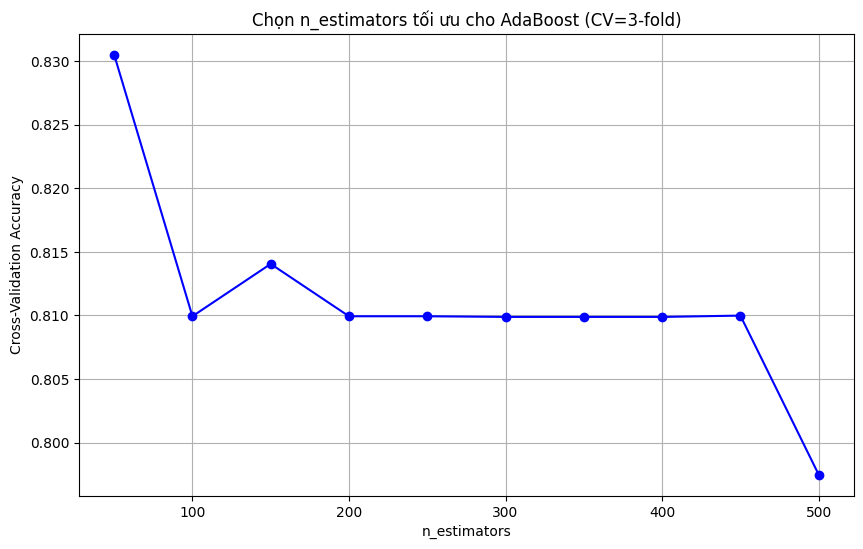


Độ chính xác AdaBoost trên tập validation: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Độ chính xác AdaBoost trên tập test: 0.8065
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       0.79      0.79      0.79        14

    accuracy                           0.81        31
   macro avg       0.80      0.80      0.80        31
weighted avg       0.81      0.81      0.81        31



In [8]:
ada_model, val_acc, best_params = evaluate_val_ada(
    X_train, y_train, X_val, y_val
)
test_acc = evaluate_test_ada(ada_model, X_test, y_test)

### 3.2 AB on FE Dataset

Tìm n_estimators tối ưu cho AdaBoost...
Đang kiểm tra các giá trị n_estimators: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
n_estimators tối ưu (CV): 100
n_estimators tối ưu (CV): 100


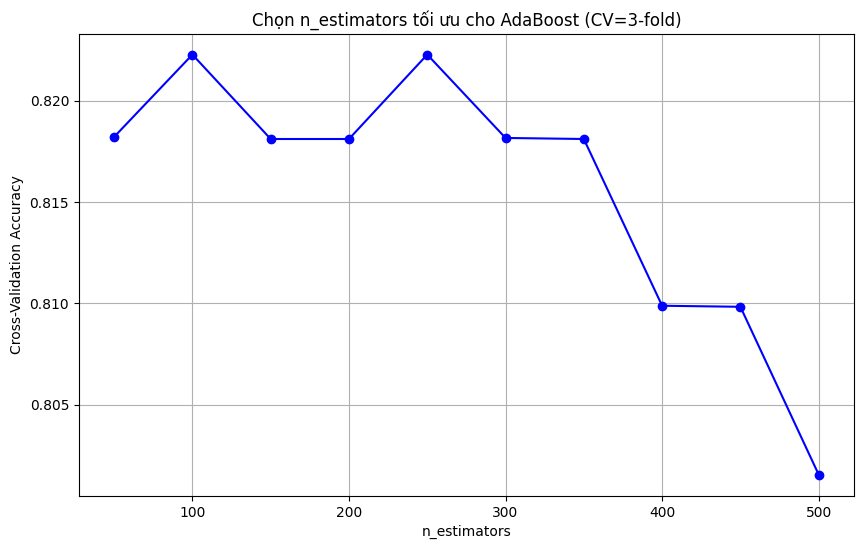


Độ chính xác AdaBoost trên tập validation: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Độ chính xác AdaBoost trên tập test: 0.8387
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.80      0.86      0.83        14

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31


Độ chính xác AdaBoost trên tập test: 0.8387
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.80    

In [9]:
# --- Huấn luyện và đánh giá trên bộ FE ---
ada_model, val_fe_acc, best_params = evaluate_val_ada(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val
)
test_fe_acc = evaluate_test_ada(ada_model, X_fe_test, y_fe_test)


### 3.3 AB on Original DT Dataset

Tìm n_estimators tối ưu cho AdaBoost...
Đang kiểm tra các giá trị n_estimators: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
n_estimators tối ưu (CV): 50
n_estimators tối ưu (CV): 50


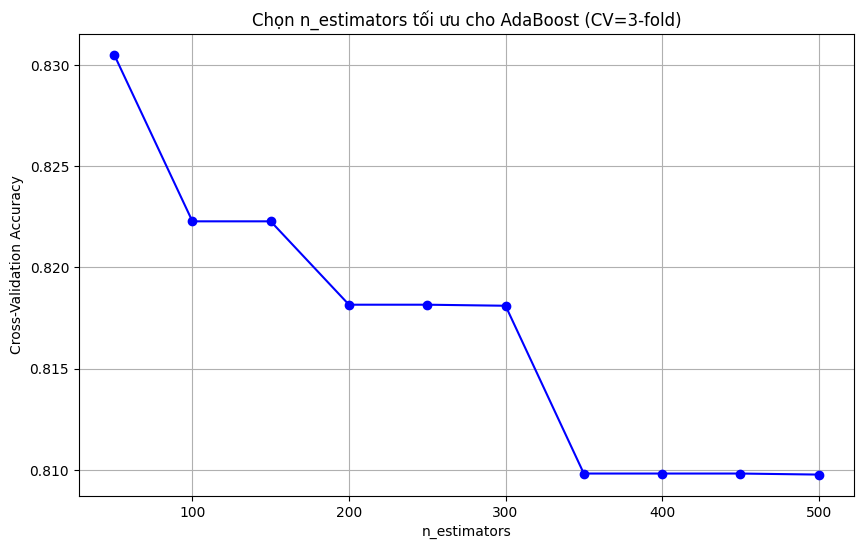


Độ chính xác AdaBoost trên tập validation: 0.9667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Độ chính xác AdaBoost trên tập test: 0.8065
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       0.79      0.79      0.79        14

    accuracy                           0.81        31
   macro avg       0.80      0.80      0.80        31
weighted avg       0.81      0.81      0.81        31



In [10]:
# --- Huấn luyện và đánh giá trên bộ Original + DT ---
ada_model, val_dt_acc, best_params = evaluate_val_ada(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val
)
test_dt_acc = evaluate_test_ada(ada_model, X_dt_test, y_dt_test)


### 3.4 AB on FE + DT Dataset

Tìm n_estimators tối ưu cho AdaBoost...
Đang kiểm tra các giá trị n_estimators: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
n_estimators tối ưu (CV): 50
n_estimators tối ưu (CV): 50


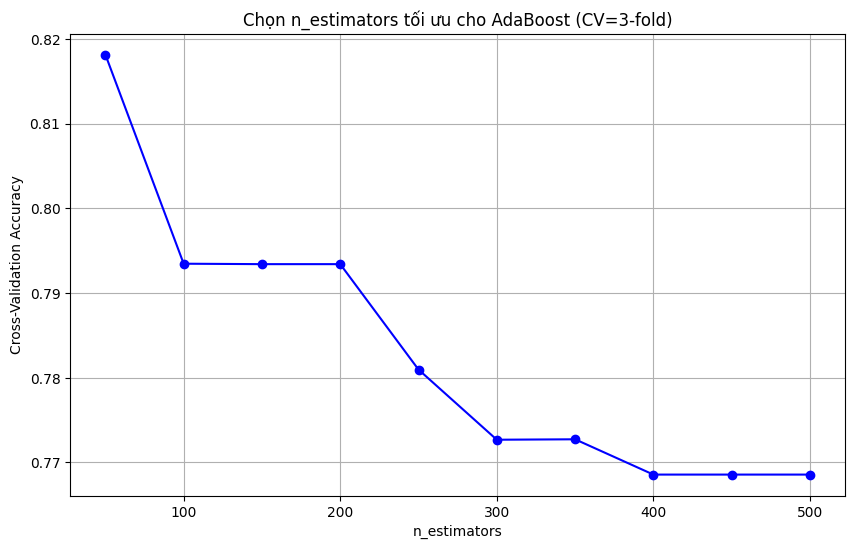


Độ chính xác AdaBoost trên tập validation: 0.9333
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Độ chính xác AdaBoost trên tập test: 0.8387
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.80      0.86      0.83        14

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31


Đã hoàn tất huấn luyện và đánh giá trên 4 bộ dữ liệu.
Đang vẽ biểu đồ tổng hợp...


In [11]:
# --- Huấn luyện và đánh giá trên bộ FE + DT ---
ada_model, val_fe_dt_acc, best_params = evaluate_val_ada(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val
)
test_fe_dt_acc = evaluate_test_ada(ada_model, X_fe_dt_test, y_fe_dt_test)
print("\n" + "="*50)
print("Đã hoàn tất huấn luyện và đánh giá trên 4 bộ dữ liệu.")
print("Đang vẽ biểu đồ tổng hợp...")


## 4.Result Visualization

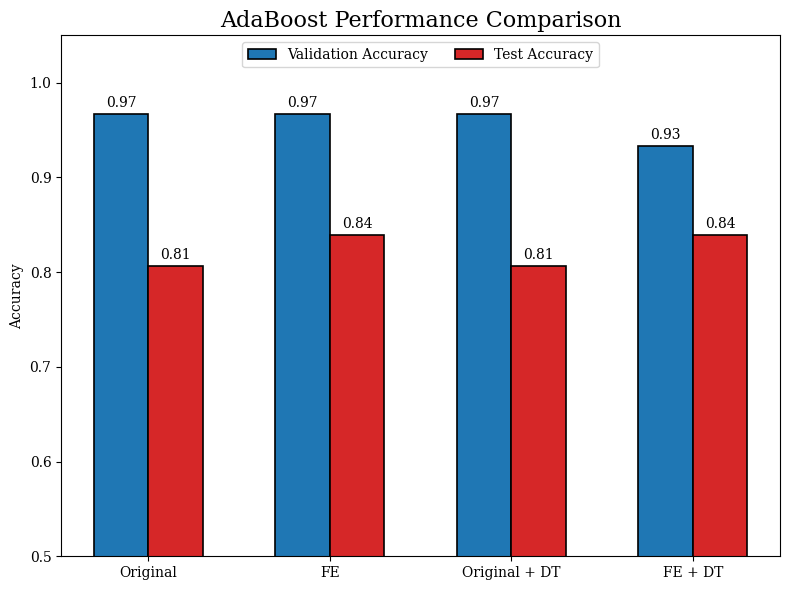

In [12]:
# --- Vẽ biểu đồ so sánh ---
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', "FE + DT"]
val_accs = [val_acc, val_fe_acc, val_dt_acc, val_fe_dt_acc]
test_accs = [test_acc, test_fe_acc, test_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, val_accs, width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('AdaBoost Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    xytext=(0, 3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()